In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from scipy.spatial.distance import euclidean

In [2]:
bp_track = pd.read_csv('data/bp_track.csv', usecols=['genre_id', 'track_id', 'title', 'bpm', 'key_id'])

In [3]:
bp_track = bp_track.dropna()

In [4]:
bp_key  = pd.read_csv('data/bp_key.csv')

In [5]:
bp_track_updated = pd.merge(bp_track, bp_key[['key_id', 'scale_numeric_value']], on='key_id', how='left')

# Drop the old 'key_id' and rename 'scale_numeric_value' to 'key_id'
bp_track = bp_track_updated.drop(columns=['key_id']).rename(columns={'scale_numeric_value': 'key_id'})

In [6]:
bp_clustering = bp_track.drop(columns=['genre_id', 'track_id', 'title'])

In [7]:
bp_clustering_sample = bp_clustering.sample(n=50000, random_state=42)
scaler = StandardScaler()

bp_clustering_sample = scaler.fit_transform(bp_clustering_sample)

In [8]:
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(4, 9)

for n_clusters in cluster_range:
    # Apply KMeans on the original feature list
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(bp_clustering_sample)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(bp_clustering_sample, clusters)
    sil_scores.append(sil_score)

# Find the number of clusters with the highest silhouette score
peak_silo = cluster_range[sil_scores.index(max(sil_scores))]

print(f"The optimal number of clusters is: {peak_silo}")

The optimal number of clusters is: 4


In [9]:
bp_clustering = scaler.fit_transform(bp_clustering)

In [10]:
# Use the peak_silo number of clusters for final model
mbkmeans = MiniBatchKMeans(n_clusters=peak_silo, batch_size=5000, random_state=42,verbose=1) 
mbkmeans_clusters = mbkmeans.fit_predict(bp_clustering)

Init 1/1 with method k-means++
Inertia for init 1/1: 10824.959828794768
Minibatch step 1/213580: mean batch inertia: 0.7294381718231235
Minibatch step 2/213580: mean batch inertia: 0.5893878334743332, ewa inertia: 0.5893878334743332
Minibatch step 3/213580: mean batch inertia: 0.6320075565449967, ewa inertia: 0.5894277432404725
Minibatch step 4/213580: mean batch inertia: 0.5937290539458843, ewa inertia: 0.5894317710541696
Minibatch step 5/213580: mean batch inertia: 0.5992765144636798, ewa inertia: 0.5894409898237642
Minibatch step 6/213580: mean batch inertia: 0.5769187153452744, ewa inertia: 0.5894292637727728
Minibatch step 7/213580: mean batch inertia: 0.5824027904934286, ewa inertia: 0.5894226840748029
Minibatch step 8/213580: mean batch inertia: 0.5827184524412663, ewa inertia: 0.5894164061288812
Minibatch step 9/213580: mean batch inertia: 0.5950911094856396, ewa inertia: 0.589421720008643
Minibatch step 10/213580: mean batch inertia: 0.5864638711465441, ewa inertia: 0.58941895

In [11]:
bp_clustering = scaler.inverse_transform(bp_clustering)

In [12]:
clustered_data = pd.DataFrame(bp_clustering, columns=['BPM', 'Key'])
clustered_data['Cluster'] = mbkmeans_clusters

# Generate summary statistics for each cluster
summary = clustered_data.groupby('Cluster').agg(['mean', 'median', 'std'])
summary

BPM                          Key                 
               mean median        std       mean median       std
Cluster                                                          
0        128.965090  126.0  10.902229  12.283335   12.0  2.468613
1         85.752030   88.0  15.875537  11.902589   12.0  6.472831
2        126.410044  125.0  10.255157   3.934163    4.0  2.293163
3        126.389497  125.0  10.445916  20.058867   19.0  2.045047

In [13]:
X = clustered_data[['BPM', 'Key']]
y = clustered_data['Cluster']

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [15]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2705013
           1       1.00      1.00      1.00   1504668
           2       1.00      1.00      1.00   2673031
           3       1.00      1.00      1.00   2728406

    accuracy                           1.00   9611118
   macro avg       1.00      1.00      1.00   9611118
weighted avg       1.00      1.00      1.00   9611118



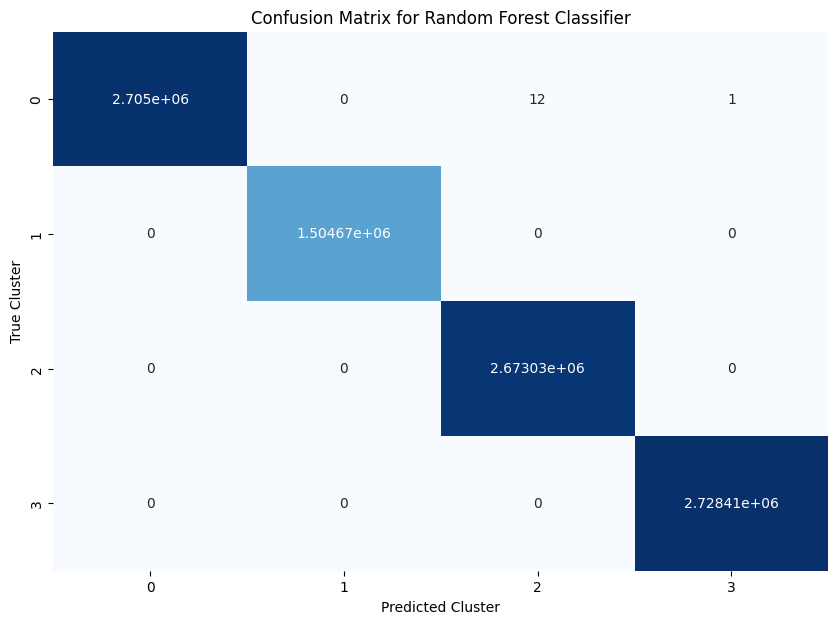

In [16]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

# Add labels and title
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

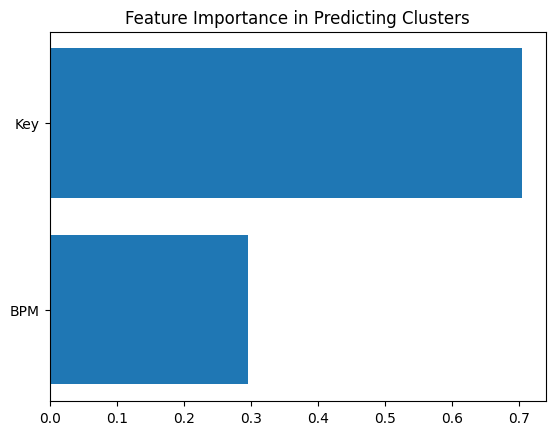

In [17]:
feature_importances = clf.feature_importances_
features = ['BPM', 'Key']

# Plot the feature importances
plt.barh(features, feature_importances)
plt.title('Feature Importance in Predicting Clusters')
plt.show()

In [18]:
bp_track['Cluster'] = mbkmeans_clusters

In [19]:
bp_song = pd.read_csv('data/bp_song.csv')

In [23]:
merged_df = pd.merge(bp_track, bp_song[['track_id', 'song']], on='track_id', how='left')
bp = merged_df.drop(columns='title')

In [24]:
bp.head()

,track_id,genre_id,bpm,key_id,Cluster,song
0,17775434,99,130,20,3,Navigator 3000 by Abdul Raeva
1,17610335,99,124,4,2,Nehorah by Ormus
2,17610338,99,124,6,2,Akawi by Ormus
3,17658499,99,93,10,1,Interplanetary Species by CJ Art
4,17658498,99,125,2,2,Echoing Planetary Motion by CJ Art


In [25]:
bp['track_id'] = bp['track_id'].astype(int)

In [26]:
def find_similar_song(input_song, song_data, n_recommendations=1):
    # Extract the features of the input song
    input_features = song_data[song_data['track_id'] == input_song][['bpm', 'key_id']].values[0]

    # Compute the Euclidean distance to all other songs
    song_data['distance'] = song_data.apply(
        lambda row: euclidean(input_features, row[['bpm', 'key_id']].values), axis=1
    )

    # Sort by the smallest distance and return the n recommendations
    recommendations = song_data.sort_values('distance').head(n_recommendations)

    return recommendations[['track_id', 'song', 'bpm', 'key_id']]

In [27]:
def recommend_songs(input_song, song_data, n_recommendations=5):
    # Find the cluster of the input song
    input_cluster = song_data[song_data['track_id'] == input_song]['Cluster'].values[0]

    # Find songs from the same cluster
    same_cluster_songs = song_data[song_data['Cluster'] == input_cluster]

    # Sort by distance in terms of features (BPM and Key)
    recommendations = find_similar_song(input_song, same_cluster_songs, n_recommendations=n_recommendations)

    return recommendations

In [28]:
# Input song and recommendations
input_song = 8438116
recommended_songs = recommend_songs(input_song, bp, n_recommendations=5)

# Output the song name, bpm, and key_id of the input song and the recommendations
input_song_info = bp[bp['track_id'] == input_song][['song', 'bpm', 'key_id']].values[0]
print(f"Input Song: {input_song_info[0]} (BPM: {input_song_info[1]}, Key: {input_song_info[2]})\n")

print("Recommended Songs:")
for index, row in recommended_songs.iterrows():
    print(f" - {row['song']} (BPM: {row['bpm']}, Key: {row['key_id']})")

C:\Users\Shank\AppData\Local\Temp\ipykernel_22704\3081161967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_data['distance'] = song_data.apply(


Input Song: Baila by Modium (BPM: 126, Key: 14)

Recommended Songs:
 - Guanatos by Mark Pizzonia (BPM: 126, Key: 14)
 - Second Life by Ouardia Haisma (BPM: 126, Key: 14)
 - I Can't Stop by Michael Push (BPM: 126, Key: 14)
 - Outta My Mind by Joe Maz (BPM: 126, Key: 14)
 - By My Side by Chris Davids (BPM: 126, Key: 14)


In [29]:
bp_tabular = bp

In [30]:
bp_tabular.to_csv('data/bp_tabular.csv',index=False)